In [1]:
import math
import h5py
import scipy
import random
import scipy.io as scio
from PIL import Image
from scipy import ndimage
from tensorflow.python.framework import ops
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pydot
from matplotlib.pyplot import imshow

%matplotlib inline
np.random.seed(1)

In [2]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y


def max_min_normalization(data_array):
    rows = data_array.shape[0]
    cols = data_array.shape[1]
    
    temp_array = np.zeros((rows,cols))
    col_min = data_array.min(axis=0)
    col_max = data_array.max(axis=0)

    for i in range(0,rows,1):
        for j in range(0,cols,1):
            temp_array[i][j] = (data_array[i][j]-col_min[j])/(col_max[j]-col_min[j])
    return temp_array


def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches


In [3]:
"下载数据和标签"
f = scio.loadmat('db1.mat')
data  = f['features'][:,0:100]
label = f['features'][:,100] 

"随机打乱数据和标签"
N = data.shape[0]
index = np.random.permutation(N)
data  = data[index,:]
label = label[index]

"对数据特征归一化"
data = max_min_normalization(data)

"将label的数据类型改成int,将label的数字都减1"
label = label.astype(int)
label = label - 1

"转换标签为one-hot"
label = label.reshape((1,label.shape[0]))
label = convert_to_one_hot(label,52)
data = data.T

"生成训练样本及标签、测试样本及标签"
num_train = round(N*0.8)
num_test  = N-num_train

train_data  = data[:,0:num_train]
test_data   = data[:,num_train:N]
train_label = label[:,0:num_train]
test_label  = label[:,num_train:N]

print("train data shape:",train_data.shape)
print("train label shape:",train_label.shape)
print("test data shape:",test_data.shape)
print("test label shape:",test_label.shape)

X_train = train_data
Y_train = train_label
X_test  = test_data
Y_test  = test_label

train data shape: (100, 7238)
train label shape: (52, 7238)
test data shape: (100, 1809)
test label shape: (52, 1809)


In [4]:
# 1-1、创建占位符
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.

    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)

    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"

    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """
    X = tf.placeholder(tf.float32, shape = [n_x, None])
    Y = tf.placeholder(tf.float32, shape = [n_y, None])
    return X, Y


# 1-2、初始化参数
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [200, 100]
                        b1 : [200, 1]
                        W2 : [150, 200]
                        b2 : [150, 1]
                        W3 : [52, 150]
                        b3 : [52, 1]

    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    tf.set_random_seed(1)       # so that your "random" numbers match ours

    W1 = tf.get_variable("W1", [200,100],  initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [200,1],    initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [150,200],  initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [150,1],    initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [52,150],   initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [52,1],     initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}

    return parameters


# 1-3、TensorFlow中的前向传播
# tf中前向传播停止在z3，是因为tf中最后的线性层输出是被作为输入计算loss，不需要a3
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX

    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

  
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3

    return Z3

# 1-4、计算成本函数
def compute_cost(Z3, Y):
    """
    Computes the cost

    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3

    Returns:
    cost - Tensor of the cost function
    """
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)

    # 函数输入：shape =（样本数，类数）
    # tf.reduce_mean()
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))

    return cost


In [5]:
# 1-6、建立模型
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.005,
          num_epochs = 2001, minibatch_size = 32, print_cost = True):

    ops.reset_default_graph()      # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)          # to keep consistent results
    seed = 3                       # to keep consistent results
    (n_x, m) = X_train.shape       # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]         # n_y : output size
    costs = []                     # To keep track of the cost

    X, Y = create_placeholders(n_x, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    
    # 开始tf会话，计算tf图
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            epoch_cost = 0.                           # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches 
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch

                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict = {X: minibatch_X, Y: minibatch_Y})

                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 10 == 0:
                costs.append(epoch_cost)

        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # 将parameters保存在一个变量中
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:",  accuracy.eval({X: X_test, Y: Y_test}))

        return parameters
    



Cost after epoch 0: 2.748814
Cost after epoch 100: 0.150585
Cost after epoch 200: 0.092542
Cost after epoch 300: 0.085290
Cost after epoch 400: 0.137196
Cost after epoch 500: 0.095159
Cost after epoch 600: 0.105911
Cost after epoch 700: 0.157943
Cost after epoch 800: 0.146498
Cost after epoch 900: 0.100920
Cost after epoch 1000: 0.056445
Cost after epoch 1100: 0.218866
Cost after epoch 1200: 0.160215
Cost after epoch 1300: 0.203370
Cost after epoch 1400: 0.324872
Cost after epoch 1500: 0.048606
Cost after epoch 1600: 0.045279
Cost after epoch 1700: 0.000000
Cost after epoch 1800: 0.000000
Cost after epoch 1900: 0.000000
Cost after epoch 2000: 0.000000


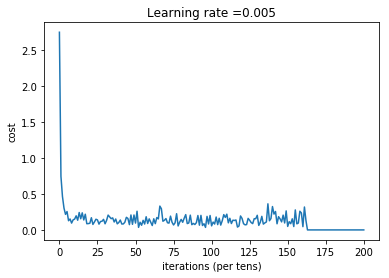

Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 0.752902


In [6]:
parameters = model(X_train, Y_train, X_test, Y_test)